### 链家网租房数据分析：可视化与房租预测模型

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib
import requests
from urllib.request import urlopen, quote
plt.rcParams['font.sans-serif'] = ['SimHei']

对上海地区所有整租房的租房信息进行数据的预处理，具体内容包括：

1. 确保只有整租房信息：
   - 直接筛选出“整租非独栋”列

2. 剔除暂不研究的列：图片链接、看房、租赁方式(都为整租)、燃气（数据缺失）

3. 确保以下数据的合理性：
   - 租金一定为正整数
   - 房子面积不可小于六平米（官网存在“一平米房”的错误数据）
   - 房子面积不可大于三千平米（官网存在几万平方米的错误数据）
   - 房子面积一定为正数
   - 房源小区一定为一串字符串  
  


4. 删除缺失值、重复值


In [769]:
dt = pd.read_csv("上海地区房源信息总数据.csv")
dt = dt[dt['租赁方式'] == '整租非独栋']
dt = dt.drop(['图片链接', '看房', '租赁方式','燃气'], axis=1)
dt = dt[dt['租金'].str.match(r'^\d+$')]
dt = dt[dt['房子面积'].astype(float) >= 6] #删除房子面积小于6平米的行
dt = dt[dt['房子面积'].astype(float) <= 3000] #删除房子面积大于3000平米的行
dt = dt[dt['房子面积'].str.match(r'^\d+(\.\d+)?$')]  # 正则表达式匹配正整数或正小数
dt = dt[dt['房源小区'].apply(lambda x: isinstance(x, str))]
dt = dt.loc[ : , ~dt.columns.str.contains("^Unnamed")]
dt = dt.dropna() # 删除缺失值
dt = dt.drop_duplicates() # 删除重复值
dt.to_csv("data_new.csv", index=False, encoding="utf-8-sig")

data = pd.read_csv("data_new.csv", encoding="utf-8-sig")

D:\temp/ipykernel_25468/3885535433.py:1: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv("上海地区房源信息总数据.csv")


我们首先进行六次必要的可视化操作，以对初步清洗后的数据拥有更为直观的了解。

可视化操作1：各区域租房房源数量排行情况

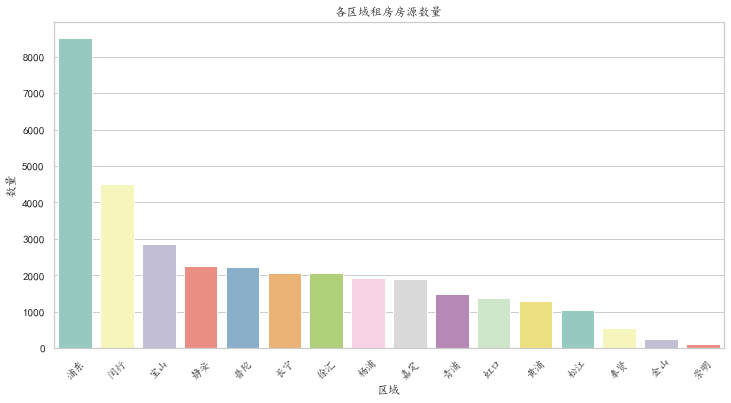

In [770]:

# 使用Seaborn设置样式
sns.set(style="whitegrid")
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']

# 计算各区域的房源数量并排序
region_counts = data['区域'].value_counts().reset_index()
region_counts.columns = ['区域', '房源数量']
region_counts = region_counts.sort_values(by='房源数量', ascending=False)

# 绘制柱状图
plt.figure(figsize=(12, 6))  # 设置图形大小

# 使用Seaborn的barplot绘制排序后的各区域的房源数量柱状图
sns.barplot(data=region_counts, x='区域', y='房源数量', palette='Set3')

# 添加标题和标签
plt.title('各区域租房房源数量')
plt.xlabel('区域')
plt.ylabel('数量')

# 旋转x轴标签以提高可读性
plt.xticks(rotation=45)

# 显示图形
plt.show()

可视化操作2：
对各个区域的租房价格与每平米单价进行排名可视化。

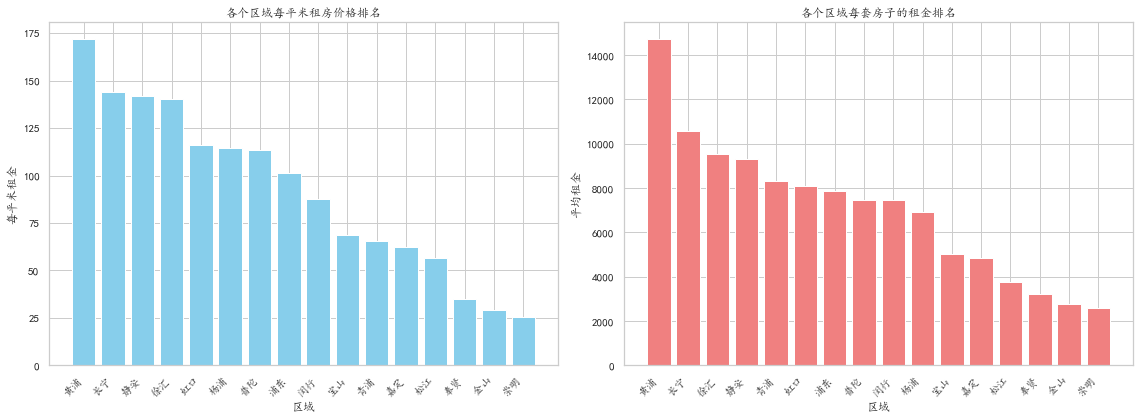

In [771]:
# 计算每平米租房价格
data['每平米租金'] = data['租金'] / data['房子面积']

# 按区域分组，并计算每个区域的平均每平米租金
avg_price_by_area = data.groupby('区域')['每平米租金'].mean().reset_index()

# 按平均每平米租金降序排序
avg_price_by_area = avg_price_by_area.sort_values(by='每平米租金', ascending=False)

# 按区域分组，并计算每个区域的平均租金
avg_rent_by_area = data.groupby('区域')['租金'].mean().reset_index()

# 按平均租金降序排序
avg_rent_by_area = avg_rent_by_area.sort_values(by='租金', ascending=False)

# 设置颜色
colors = ['skyblue', 'lightcoral']

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 绘制每平米租金排名图
ax1.bar(avg_price_by_area['区域'], avg_price_by_area['每平米租金'], color=colors[0])
ax1.set_xlabel('区域')
ax1.set_ylabel('每平米租金')
ax1.set_title('各个区域每平米租房价格排名')

# 使用FixedLocator设置刻度位置和标签
ax1.set_xticks(np.arange(len(avg_price_by_area)))
ax1.set_xticklabels(avg_price_by_area['区域'], rotation=45, ha='right')

# 绘制平均租金排名图
ax2.bar(avg_rent_by_area['区域'], avg_rent_by_area['租金'], color=colors[1])
ax2.set_xlabel('区域')
ax2.set_ylabel('平均租金')
ax2.set_title('各个区域每套房子的租金排名')

# 使用FixedLocator设置刻度位置和标签
ax2.set_xticks(np.arange(len(avg_rent_by_area)))
ax2.set_xticklabels(avg_rent_by_area['区域'], rotation=45, ha='right')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

可视化操作3：对每平米租金最高与最便宜的十个小区及其区域信息的可视化

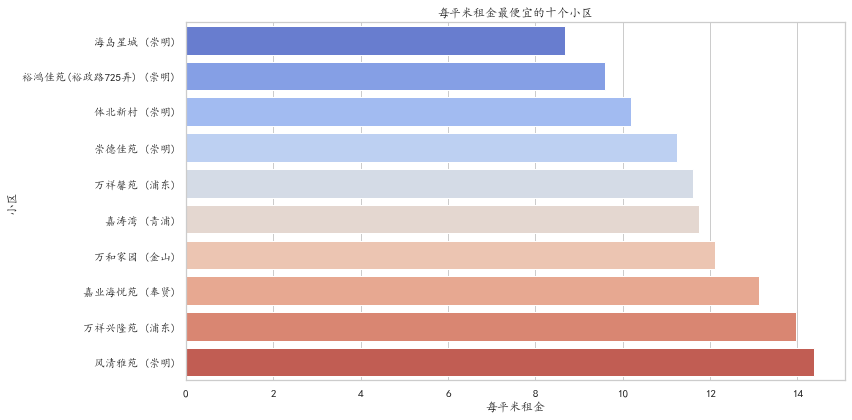

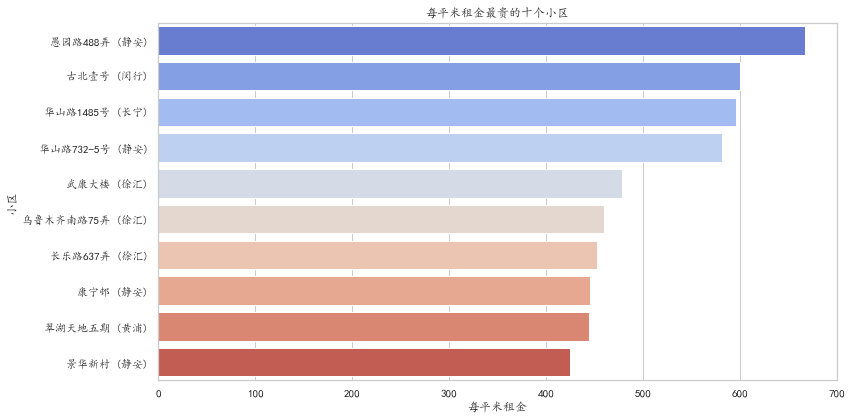

In [772]:
# 按小区分组，计算每个小区的平均每平米租金
avg_price_by_community = data.groupby('房源小区')['每平米租金'].mean().reset_index()

# 按每平米租金排序
sorted_communities = avg_price_by_community.sort_values(by='每平米租金')

# 获取最便宜和最贵的十个小区及其区域信息
bottom_10_communities = sorted_communities.head(10)
top_10_communities = sorted_communities.tail(10)

# 反转top_10_communities的顺序
top_10_communities = top_10_communities[::-1]

# 添加区域信息到bottom_10_communities和top_10_communities
bottom_10_communities = pd.merge(bottom_10_communities, data[['房源小区', '区域']], on='房源小区', how='left')
top_10_communities = pd.merge(top_10_communities, data[['房源小区', '区域']], on='房源小区', how='left')

# 在小区名称后面标注区域信息
bottom_10_communities['房源小区'] = bottom_10_communities['房源小区'] + ' (' + bottom_10_communities['区域'] + ')'
top_10_communities['房源小区'] = top_10_communities['房源小区'] + ' (' + top_10_communities['区域'] + ')'

# 绘制最便宜的十个小区的每平米租金排名情况（价格由小到大）
plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_10_communities, x='每平米租金', y='房源小区', palette='coolwarm')
plt.xlabel('每平米租金')
plt.ylabel('小区')
plt.title('每平米租金最便宜的十个小区')

# 显示图表
plt.tight_layout()
plt.show()

# 绘制最贵的十个小区的每平米租金排名情况（价格由大到小）
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_communities, x='每平米租金', y='房源小区', palette='coolwarm')
plt.xlabel('每平米租金')
plt.ylabel('小区')
plt.title('每平米租金最贵的十个小区')

# 显示图表
plt.tight_layout()
plt.show()

可视化操作4：前十种热门的户型组合

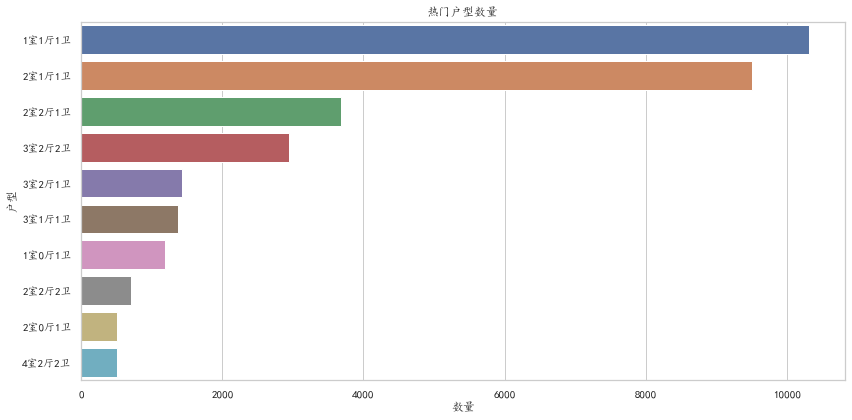

In [773]:
# 绘制户型数量条形图
plt.figure(figsize=(12, 6))
plt.title("热门户型数量")
plt.ylabel('数量')

# 计算每种户型的数量
huxing_num = data['户型'].value_counts().reset_index()
huxing_num.columns = ['户型', '数量']

# 根据数量降序排序户型
huxing_num = huxing_num.sort_values(by='数量', ascending=False)

# 只保留前十种热门户型组合
top_10_huxing = huxing_num.head(10)

# 使用seaborn绘制条形图
sns.barplot(x="数量", y="户型", data=top_10_huxing)

# 显示图表
plt.tight_layout()
plt.show()

可视化操作5：考察电梯对租房价格的影响

<AxesSubplot:xlabel='区域', ylabel='每平米租金'>

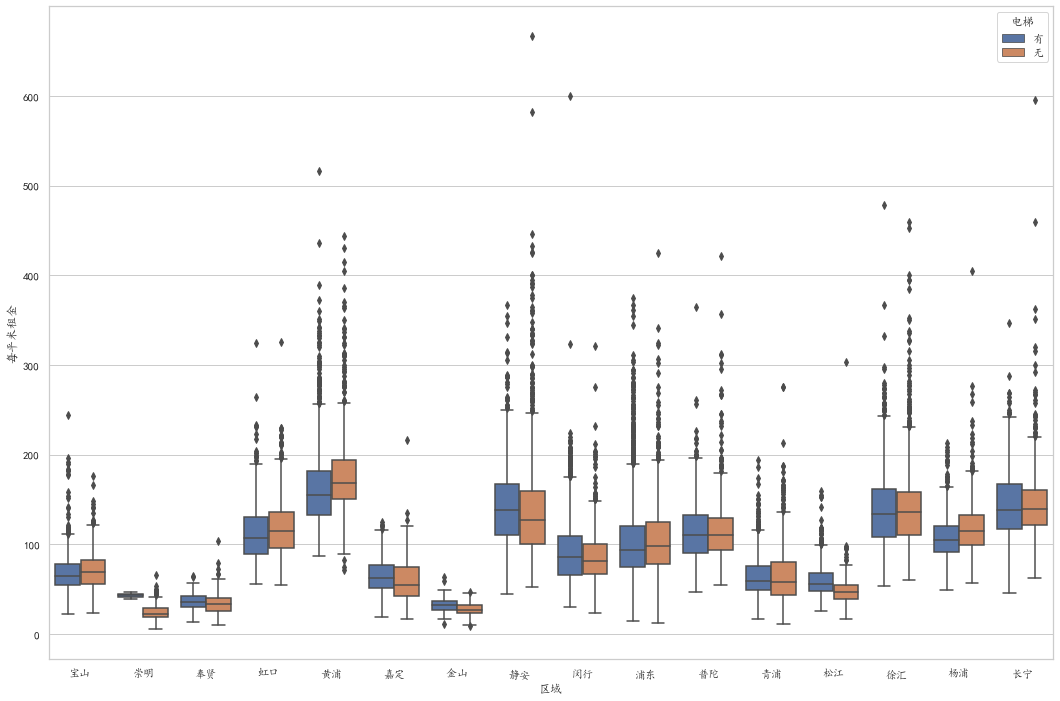

In [774]:
plt.figure(figsize=(18, 12))
sns.boxplot(x="区域", y="每平米租金", hue="电梯", data=data)

可视化操作6：价格与面积的关系

<AxesSubplot:xlabel='房子面积', ylabel='租金'>

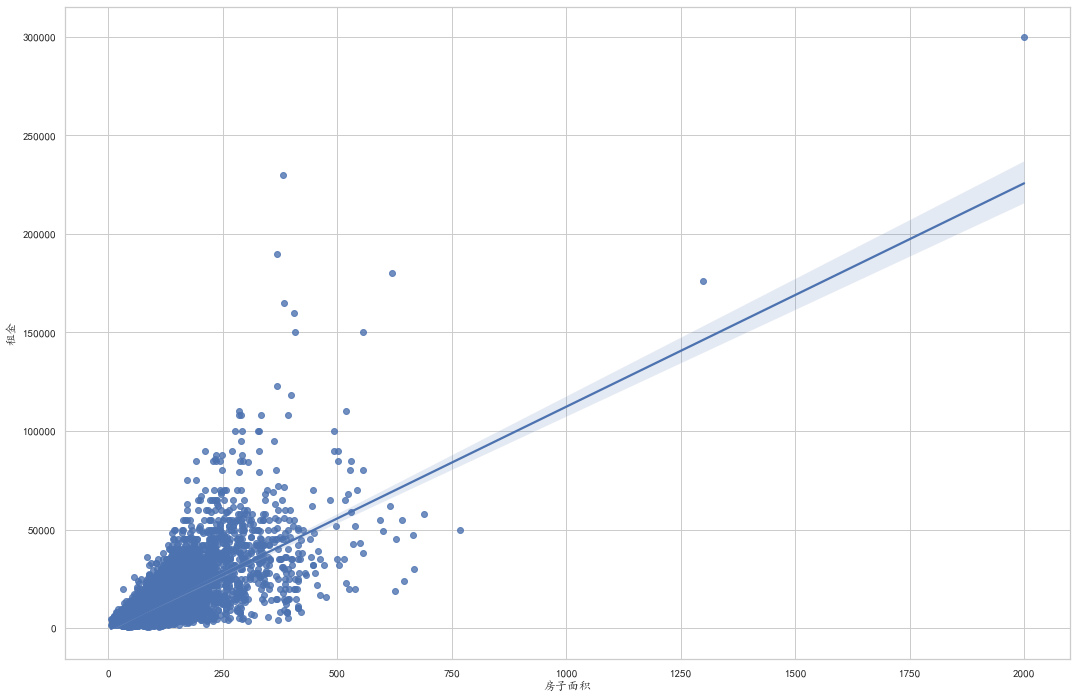

In [775]:
plt.figure(figsize=(18, 12))
sns.regplot(x='房子面积', y='租金', data=data)

#### 模型构建：房租预测模型

我们使用Scikit-Learn库来构建一个随机森林回归模型，结合现有的采集数据，尝试预测房屋租金。  
这段建模过程描述了如何使用Scikit-Learn库来构建一个随机森林回归模型，用于预测房屋租金。详细过程如下：

1. 导入必要的库：
   - 使用`import`语句导入Scikit-Learn的相关模块，包括数据分割、随机森林回归、评估指标、特征处理等。

2. 数据清洗：
   - 通过正则表达式提取并解析房屋户型数据，将室、厅、卫的数量提取为新的列。
   - 清洗楼层数据，将其分为低楼层、中楼层和高楼层，并将楼层数添加为新的列。

3. 数据预处理：
   - 使用MultiLabelBinarizer将朝向特征进行独热编码，生成多个新的二进制特征列。
   - 选择目标变量（租金）和一组特征，包括地区、楼层、室、厅、卫、房屋面积、电梯、楼层数以及朝向的独热编码列。

4. 数据分割：
   - 使用`train_test_split`函数将数据分割成训练集和测试集，其中测试集占总数据的20%。

5. 特征处理：
   - 对数值特征进行标准化，使用`StandardScaler`，以确保各个特征在相同的尺度上。
   - 对分类特征进行独热编码，使用`OneHotEncoder`，将分类特征转换为二进制的数值特征。

6. 模型构建：
   - 使用`Pipeline`构建了一个机器学习流水线，包括特征处理和随机森林回归模型。

7. 模型训练：
   - 使用训练集数据对模型进行训练，通过调用`fit`方法完成。

8. 模型评估：
   - 使用测试集数据对模型进行评估，计算了均方误差（MSE）、均方根误差（RMSE）、平均绝对误差（MAE）和决定系数（R-squared）等评估指标。这些指标用于评估模型的性能和预测准确度。

9. 模型预测：
   - 使用训练好的模型对新的数据进行租金预测，包括区域、楼层、室、厅、卫、房屋面积、电梯、楼层数和朝向的独热编码列。

10. 打印结果：
    - 打印模型评估的结果，包括MSE、RMSE、MAE和R-squared值，以及对新数据的租金预测结果。



##### 数据范围

根据可视化操作6我们可以直观的看出，绝大多数房源的租金小于50000，房子面积小于300。我们首先确定一个数据点比较集中的范围，便于后续模型的训练：

In [776]:
filtered_data = data[(data['租金'] < 40000) & (data['房子面积'] < 230)]
count_filtered = len(filtered_data)

# 计算所有房屋的数量
total_count = len(data)

# 计算比例
percentage = (count_filtered / total_count) * 100

print(f"满足条件的房屋占比: {percentage:.2f}%")

满足条件的房屋占比: 97.97%


该房屋占比较高，故我们把data确定在上述范围即可。  
下面我们开始构建具体的预测模型。为了提取尽可能多的数值变量，我们进一步清洗数据，以获得详细的户型数量。  
1. 在model_0中，我们使用了尽量多的特征。  
2. 在model_1中，我们尝试删去了有关楼层的信息，发现绝对系数升高了，而删去其他数据都会使绝对系数下降。这说明楼层信息对于预测房租反而存在干扰效果。  
3. 在model_2中，我们尝试对每平米房租价格进行预测，因此我们保留了租金这一数据，而删去了房子面积这一数据。（否则每平米房租便可以直接计算了，绝对系数基本为1）
    发现model_2的预测结果相对可观。这为我们提供了一个实际的应用场景：  
    预期租房者往往对于区域、户型、租金预算、电梯等数据有着自己的打算和预想，租房者便可以利用该模型求得预测的每平米单价，从而对预期居住房子的面积信息有所了解。

In [777]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# 清洗户型数据，提取室、厅、卫的数量
data['室'] = data['户型'].str.extract('(\d+)室').astype(int)
data['厅'] = data['户型'].str.extract('(\d+)厅').astype(int)
data['卫'] = data['户型'].str.extract('(\d+)卫').astype(int)
data = data[data['楼层'].str.contains('/')]


# 清洗楼层数据，将其分为低、中、高楼层
def categorize_floor(floor_str):
    if floor_str[0].isdigit():
        current_floor = int(floor_str.split('/')[0])
        total_floor = int(floor_str.split('/')[1].replace('层', ''))
        floor_ratio = current_floor / total_floor
        if floor_ratio <= 0.3:
            return '低楼层'
        elif floor_ratio <= 0.7:
            return '中楼层'
        else:
            return '高楼层'
    elif '中楼层' in floor_str:
        return '中楼层'
    elif '低楼层' in floor_str:
        return '低楼层'
    else:
        return '高楼层'

def categorize_floor_num(floor_str):
    if floor_str[0].isdigit():
        return int(floor_str.split('/')[0])
    else:
        return int(floor_str.split('/')[1].replace('层', ''))

def categorize_subway(subway_str):
    if subway_str[0].isdigit():
        current_subway = float(subway_str)
        # if current_subway <= 1000:
        #     return '1'
        # elif current_subway <= 2000:
        #     return '2'
        # else:
        #     return '3'
        return current_subway
    else:
        return float(5000)


data['楼层数'] = data['楼层'].apply(categorize_floor_num)
data['楼层'] = data['楼层'].apply(categorize_floor)
data['地铁远近'] = data['平均地铁距离'].apply(categorize_subway)

data = data[data['电梯'].isin(['有', '无'])]
# 删除'房源小区'列不是字符串的行
data = data[data['房源小区'].apply(lambda x: isinstance(x, str))]

#data范围的筛选
data[(data['租金'] < 40000) & (data['房子面积'] < 230)]


def model_0():
    # 处理"朝向"特征，使用独热编码
    mlb = MultiLabelBinarizer()
    encoded_directions = mlb.fit_transform(data['朝向'].str.split())
    direction_columns = [f'朝向_{direction}' for direction in mlb.classes_]

    # 将编码后的朝向数据添加到DataFrame中
    data_encoded = pd.concat([data, pd.DataFrame(encoded_directions, columns=direction_columns)], axis=1)

    # 目标变量
    y = data_encoded['租金']

    # 特征选择
    features = ['区域', '楼层', '室', '厅', '卫', '房子面积', '电梯', '楼层数', '地铁远近','用水','用电'] + direction_columns
    X = data_encoded[features]

    # 数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征处理
    numeric_features = ['室', '厅', '卫', '房子面积', '楼层数', '地铁远近']
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Include a new transformer for 'directions' using OneHotEncoder
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
            ('directions', OneHotEncoder(), direction_columns)  # Include 'directions' for one-hot encoding
        ])

    # 构建模型，使用随机森林回归
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # 训练模型
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Model 0 result:\n")
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    

    # 使用模型进行预测
    # new_data = pd.DataFrame({'区域': ['宝山'], '楼层': ['中楼层'], '室': [2], '厅': [1], '卫': [1], '房子面积': [60], '电梯': ['有'],
    #                         '朝向_东': [0], '朝向_北': [0], '朝向_未知': [0], '朝向_西': [0], '朝向_南': [1], '朝向_西南': [0], '朝向_西北': [0],
    #                         '朝向_东北': [0], '朝向_东南': [0], '楼层数': [6], '地铁远近': [5000], '用水':['民水'],'用电':['民电'] })

    # predicted_rent = model.predict(new_data)

    # print(f'预测租金: {predicted_rent[0]}')
    print("----------------------------------")


def model_1():
    # 处理"朝向"特征，使用独热编码
    mlb = MultiLabelBinarizer()
    encoded_directions = mlb.fit_transform(data['朝向'].str.split())
    direction_columns = [f'朝向_{direction}' for direction in mlb.classes_]

    # 将编码后的朝向数据添加到DataFrame中
    data_encoded = pd.concat([data, pd.DataFrame(encoded_directions, columns=direction_columns)], axis=1)

    # 目标变量
    y = data_encoded['租金']

    # 特征选择
    features = ['区域', '室', '厅', '卫', '房子面积', '电梯', '地铁远近','用水','用电'] + direction_columns
    X = data_encoded[features]

    # 数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征处理
    numeric_features = ['室', '厅', '卫', '房子面积',  '地铁远近']
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Include a new transformer for 'directions' using OneHotEncoder
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
            ('directions', OneHotEncoder(), direction_columns)  # Include 'directions' for one-hot encoding
        ])

    # 构建模型，使用随机森林回归
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # 训练模型
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Model 1 result:\n")
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    

    # 使用模型进行预测
    # new_data = pd.DataFrame({'区域': ['宝山'], '室': [2], '厅': [1], '卫': [1], '房子面积': [60], '电梯': ['有'],
    #                         '朝向_东': [0], '朝向_北': [0], '朝向_未知': [0], '朝向_西': [0], '朝向_南': [1], '朝向_西南': [0], '朝向_西北': [0],
    #                         '朝向_东北': [0], '朝向_东南': [0],  '地铁远近': [5000], '用水':['民水'],'用电':['民电']})

    # predicted_rent = model.predict(new_data)

    # print(f'预测租金: {predicted_rent[0]}')
    print("----------------------------------")


def model_2():
    # 处理"朝向"特征，使用独热编码
    mlb = MultiLabelBinarizer()
    encoded_directions = mlb.fit_transform(data['朝向'].str.split())
    direction_columns = [f'朝向_{direction}' for direction in mlb.classes_]

    # 将编码后的朝向数据添加到DataFrame中
    data_encoded = pd.concat([data, pd.DataFrame(encoded_directions, columns=direction_columns)], axis=1)

    # 目标变量
    y = data_encoded['每平米租金']

    # 特征选择
    features = ['区域', '室', '厅', '卫', '租金','电梯', '地铁远近','用水','用电'] + direction_columns
    X = data_encoded[features]

    # 数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征处理
    numeric_features = ['室', '厅', '卫', '租金', '地铁远近']
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Include a new transformer for 'directions' using OneHotEncoder
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
            ('directions', OneHotEncoder(), direction_columns)  # Include 'directions' for one-hot encoding
        ])

    # 构建模型，使用随机森林回归
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # 训练模型
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Model 2 result:\n")
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    

    # 使用模型进行预测
    # new_data = pd.DataFrame({'区域': ['宝山'], '室': [2], '厅': [1], '卫': [1], '电梯': ['有'], '租金':[4000],
    #                         '朝向_东': [0], '朝向_北': [0], '朝向_未知': [0], '朝向_西': [0], '朝向_南': [1], '朝向_西南': [0], '朝向_西北': [0],
    #                         '朝向_东北': [0], '朝向_东南': [0],  '地铁远近': [5000], '用水':['民水'],'用电':['民电']})

    # predicted_rent = model.predict(new_data)

    # print(f'每平米预测租金: {predicted_rent[0]}')
    print("----------------------------------")


model_0() # '区域', '楼层', '室', '厅', '卫', '房子面积', '电梯', '楼层数', '地铁远近', '用水', '用电' + 朝向
model_1() # '区域', '室', '厅', '卫', '房子面积', '电梯',  '地铁远近', '用水', '用电' + 朝向 目前最佳
model_2()




Model 0 result:

Mean Squared Error: 22107349.955460314
Root Mean Squared Error: 4701.845377663999
Mean Absolute Error: 1597.7322121130476
R-squared: 0.6924550763898092
----------------------------------
Model 1 result:

Mean Squared Error: 21267626.037462015
Root Mean Squared Error: 4611.683644555643
Mean Absolute Error: 1640.6049152048643
R-squared: 0.7041368396375407
----------------------------------
Model 2 result:

Mean Squared Error: 510.384676297876
Root Mean Squared Error: 22.591694852265423
Mean Absolute Error: 13.82638657169221
R-squared: 0.775758574822424
----------------------------------


楼层信息对于预测租金的误导作用可能与楼层高低程度判定的标准不一有关。例如同样是第6层，对于不同的房型来说，既可以是低楼层，也可以是中高楼层。

##### 加入坐标信息（经纬度）

下面我们为获取经纬度信息做一些前置工作，包括获取ak，筛选出特定数量的数据以获得位置信息。  
调用百度地图api，根据小区名称获取该房源的准确经纬度信息。    
由于有约几千条数据的获取额度上限，故在此只选取静安区的两千条房源数据作为参考。 

(下列代码的注释部分为api调用部分，将处理后的文件存为backup_jingan的csv文件)

In [778]:
import random
def address2latlng(address):
    url = 'http://api.map.baidu.com/geocoding/v3/'
    address = quote(address) # 防止中文地址导致乱码，先用quote方法编码
    city = quote('上海')
    output='json'
    ak = 'Ns9hiSPiy1e1nC50SGbVLojqGNbq30ag'
    uri = url + '?address=' + address + '&output=' + output + '&ak=' + ak + '&city=' + city
    req = requests.get(uri)
    try:
        temp = req.json()
        lat = temp['result']['location']['lat']  # 纬度值
        lng = temp['result']['location']['lng']  # 经度值
        return lat, lng
    except Exception as e:
        print(f"Error getting coordinates for {address}: {str(e)}")
        return None, None

def get_lat_lng(row):
    row['纬度'], row['经度'] = address2latlng(row['房源小区'])
    return row

# new_data = pd.DataFrame(columns=data.columns)

# # 随机选取区域为 "静安" 的一千行数据
# jingan_data = data[data['区域'] == '静安']

# # 如果静安数据的行数不足一千行，可以选择全部静安数据
# if len(jingan_data) <= 2000:
#     new_data = jingan_data
# else:
#     # 如果静安数据的行数超过一千行，随机选择一千行
#     random_indices = random.sample(range(len(jingan_data)), 2000)
#     new_data = jingan_data.iloc[random_indices]


# new_data = new_data.apply(get_lat_lng, axis=1)
# new_data = new_data[(new_data['纬度'].notnull()) & (new_data['经度'].notnull())]
# new_data.to_csv("data_test_position.csv", index=False, encoding="utf-8-sig")

new_data = pd.read_csv("backup_jingan.csv", encoding="utf-8-sig")

我们获取这两千条房源数据的经纬度信息后，再套用之前的预测模型，观察R-squared会否增加。加入坐标信息的静安区预测模型记作model_3

In [779]:
def model_3():
    # 处理"朝向"特征，使用独热编码
    mlb = MultiLabelBinarizer()
    encoded_directions = mlb.fit_transform(new_data['朝向'].str.split())
    direction_columns = [f'朝向_{direction}' for direction in mlb.classes_]

    # 将编码后的朝向数据添加到DataFrame中
    data_encoded = pd.concat([new_data, pd.DataFrame(encoded_directions, columns=direction_columns)], axis=1)

    # 目标变量
    y = data_encoded['租金']

    # 特征选择
    features = ['纬度','经度','室', '厅', '卫', '房子面积', '电梯', '地铁远近','用水','用电'] + direction_columns
    X = data_encoded[features]

    # 数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # 特征处理
    numeric_features = ['纬度','经度','室', '厅', '卫', '房子面积',  '地铁远近']
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Include a new transformer for 'directions' using OneHotEncoder
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features),
            ('directions', OneHotEncoder(), direction_columns)  # Include 'directions' for one-hot encoding
        ])

    # 构建模型，使用随机森林回归
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # 训练模型
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Model 3 result:\n")
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    print("----------------------------------")

model_3()

Model 3 result:

Mean Squared Error: 20353461.75490712
Root Mean Squared Error: 4511.481104350003
Mean Absolute Error: 1846.026785674603
R-squared: 0.8224693189386549
----------------------------------


该结果显示经纬度信息对于模型的预测有着显著的提升作用，符合我们的预期。也可以猜想，如果把全上海市房源的经纬度信息都获取到，那么之前的model_1与model_2的决定系数将会更加趋近于1.  

#### 小结

综上所述，我们构建了基于['纬度','经度','区域','室', '厅', '卫', '房子面积', '电梯', '地铁远近','用水','用电','朝向']这些数据的预测模型，并且逐一验证了添加这些信息有助于提升模型的绝对系数。其中，'纬度','经度'，'区域'的提升效果尤为明显（反过来理解就是，删去这些数据将会使得模型预测效果迅速变差）。  

由于条件限制未能获取所有租房的经纬度信息，但是基本可以预测出这些信息将使得预测模型达到决定系数大于0.8的良好的程度。而本报告已经实现的model_1的决定系数也超过了0.7，说明仍具有一定的预测能力。  

此外在可视化方面，对于房源描述的词云绘制、结合全上海经纬度信息的租房热力图（仍需要调用api）将会是下一步可能的工作。